In [1]:
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
import matplotlib
from matplotlib import cm, colors
import sys, os, pickle

retrain_models = False

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [253, 252, 144],
            [239, 142, 192],
            [140, 194, 250],
            [214, 134, 48],
            [85, 35, 157],
            [114, 245, 144],
            [151, 38, 20],
            [72, 160, 162],
        ]
    )
    / 256
)


In [2]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


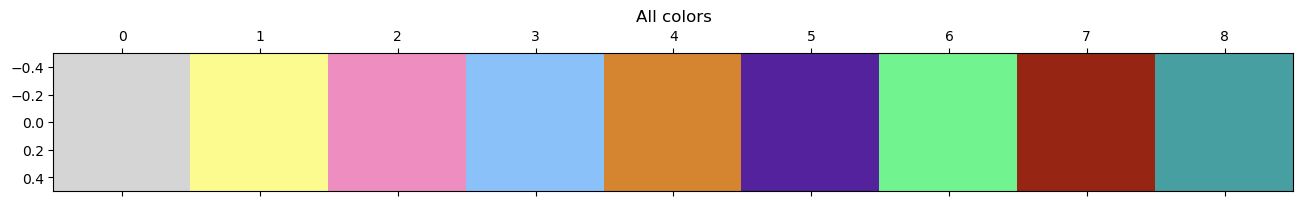

In [3]:


all_colors_room = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8]])


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors)
plt.matshow(all_colors_room, cmap=cmap)

plt.title('All colors')
plt.savefig("figures/all_colors_room.pdf")

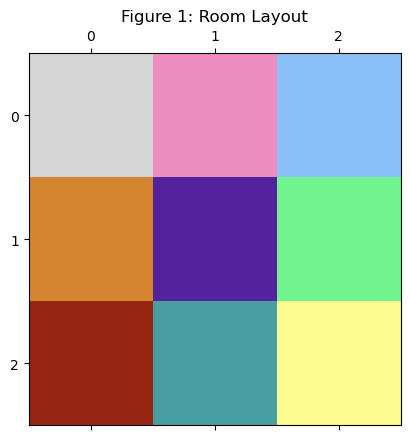

In [4]:
unique_room = np.array([
    [0, 2, 3],
    [4, 5, 6],
    [7, 8, 1]
])
n_emissions = np.max(unique_room) + 1

# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[:n_emissions])
plt.matshow(unique_room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/unique_room.pdf")

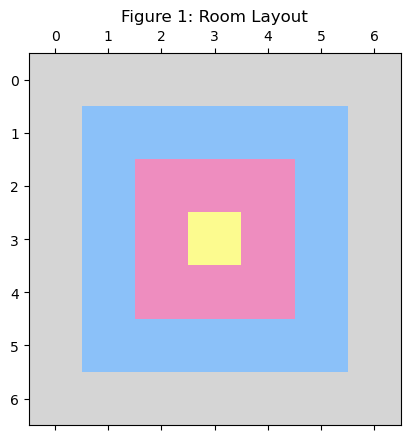

In [5]:
symmetrical_room = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 3, 3, 3, 3, 3, 0],
    [0, 3, 2, 2, 2, 3, 0],
    [0, 3, 2, 1, 2, 3, 0],
    [0, 3, 2, 2, 2, 3, 0],
    [0, 3, 3, 3, 3, 3, 0],
    [0, 0, 0, 0, 0, 0, 0]
])
n_emissions = np.max(symmetrical_room) + 1

# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[:n_emissions])
plt.matshow(symmetrical_room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/symmetrical_room.pdf")

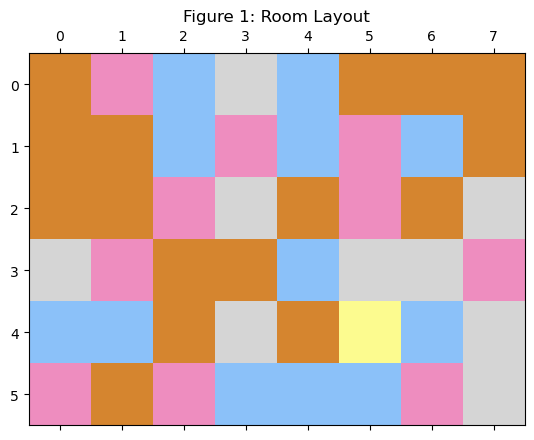

In [6]:
granular_room = np.array(
    [
        [4, 2, 3, 0, 3, 4, 4, 4],
        [4, 4, 3, 2, 3, 2, 3, 4],
        [4, 4, 2, 0, 4, 2, 4, 0],
        [0, 2, 4, 4, 3, 0, 0, 2],
        [3, 3, 4, 0, 4, 1, 3, 0],
        [2, 4, 2, 3, 3, 3, 2, 0],
    ]
)
n_emissions = np.max(granular_room) + 1

# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[:n_emissions])
plt.matshow(granular_room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/granular_room.pdf")

  2%|▏         | 2/100 [00:06<05:10,  3.17s/it, train_bps=0.00139]


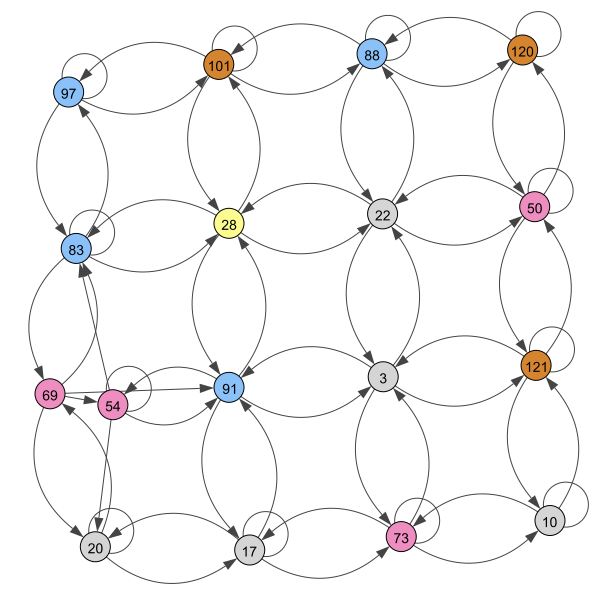

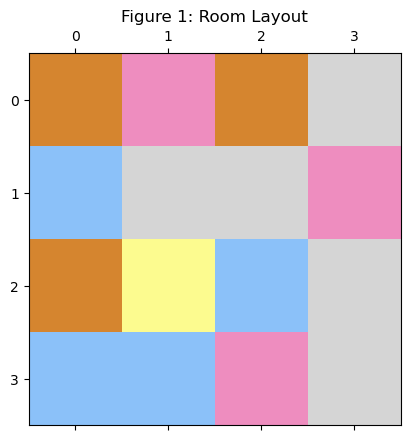

In [7]:


simple_granular_room = np.array(
    [[4, 2, 4, 0],
    [3, 0, 0, 2],
    [4, 1, 3, 0],
    [3, 3, 2, 0]]
)
n_emissions = np.max(simple_granular_room) + 1
c = np.zeros((n_emissions+1, 3))
c[:n_emissions] = custom_colors[:n_emissions]


a, x, rc = datagen_structured_obs_room(simple_granular_room, length=5000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 25

name = 'navigation-simple_granular_room'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object

chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

# Plot the layout of the room
cmap = colors.ListedColormap(c[:n_emissions])
plt.matshow(simple_granular_room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/granular_room.pdf")

file = os.path.join("figures", f"{name}.pdf")
graph = plot_graph(
    chmm, x, a, output_file=file, cmap=cmap
)
graph


In [8]:
def plot_heat_map(
    chmm, x, a, V, output_file, multiple_episodes=False, vertex_size=30
):
    # States is a list of which latent node (ie state) is most active at each time step
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)
    # A is a transition matrix of only the latent nodes (states) that get activated during walk of path

    # V_displayed represents the activity of all the nodes that are present in the A matrix/graph based on the inputted V activity for all the nodes
    V_displayed_nodes = np.zeros(v.shape)
    for i, id in enumerate(v):
        V_displayed_nodes[i] = V[id]

    # Rn skip normalizing step
    V_disp_norm = (V_displayed_nodes - np.min(V_displayed_nodes)) / (np.max(V_displayed_nodes) - np.min(V_displayed_nodes))
    V_disp_norm = V_displayed_nodes

    # colormap = cm.get_cmap('viridis')
    colormap = matplotlib.colormaps['viridis']
    colors = colormap(V_disp_norm)
    colors = [tuple(c) for c in colors]

    g = igraph.Graph.Adjacency((A > 0).tolist())

    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

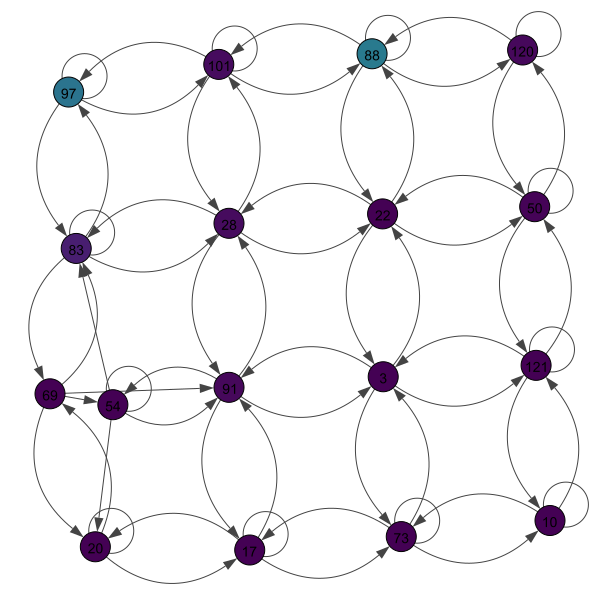

In [9]:
t = 210
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)
V = mess_fwd[t]
file = os.path.join("figures", f"{name}-heatmap{t}.png")
graph = plot_heat_map(
    chmm, x, a, V, output_file=file
    )
graph
